In [ ]:
#Lets get the helper functions ready
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-17 20:48:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-17 20:48:57 (70.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Now lets import the helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

In [ ]:
#Now import other packages
import tensorflow as tf
import numpy as np
import os
import random
import sklearn

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2021-11-17 20:49:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 74.125.70.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.6MB/s    in 37s     

2021-11-17 20:49:37 (42.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pho'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percen

In [ ]:
#Setup data inputs to become one with the data
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


The steps we are going to take
* Create a modelCheckpoint callback 
* Create a data augmentation layer to build augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned model
* Compile our model
* Feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data to save epoch time)

In [ ]:
#create a model checkpoint callback
checkpoint_path = '101_classes_10_percent_model_checkpoint.ckpt'
modelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                             save_weights_only=True,
                                                             monitor='val_accuracy',
                                                             save_best_only=True)

In [ ]:
#Create a data augmentation layer
data_augmentation = tf.keras.models.Sequential([
                                                tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                                                tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name='data_augmentation')

In [ ]:
#Lets noe setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#create trainable top layers
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
#Get the summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
#Now compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#Now fit the model for 5 epochs
history1 = model.fit(train_data,
                     steps_per_epoch=len(train_data),
                     epochs=5,
                     validation_data=test_data,
                     validation_steps=int(0.15 * len(test_data)),
                     callbacks=[modelCheckpointCallback])

Epoch 1/5
237/237 [==============================] - 150s 482ms/step - loss: 3.4656 - accuracy: 0.2557 - val_loss: 2.7889 - val_accuracy: 0.3591
Epoch 2/5
237/237 [==============================] - 95s 400ms/step - loss: 2.3441 - accuracy: 0.4593 - val_loss: 2.3781 - val_accuracy: 0.4187
Epoch 3/5
237/237 [==============================] - 84s 354ms/step - loss: 1.9791 - accuracy: 0.5315 - val_loss: 2.1767 - val_accuracy: 0.4550
Epoch 4/5
237/237 [==============================] - 80s 334ms/step - loss: 1.7621 - accuracy: 0.5754 - val_loss: 2.0888 - val_accuracy: 0.4685
Epoch 5/5
237/237 [==============================] - 76s 317ms/step - loss: 1.6001 - accuracy: 0.6054 - val_loss: 1.9948 - val_accuracy: 0.4860


In [ ]:
#Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 103s 130ms/step - loss: 1.7078 - accuracy: 0.5573


[1.707818865776062, 0.5572673082351685]

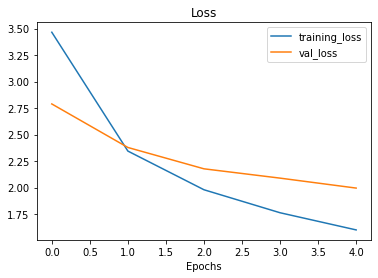

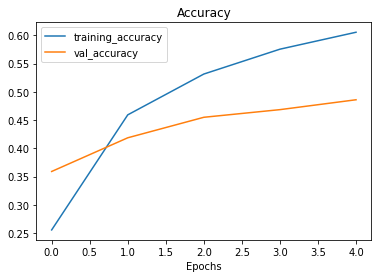

In [ ]:
plot_loss_curves(history1)

In [ ]:
#Now lets fine-tune the model by un-freezing the last 5 layers

base_model.trainable=True
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
#Now lets recompile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #lr lowered by 10x
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#Now lets fit the model by fine-tuning and start training at 6th epoch
history2 = model.fit(train_data,
                     steps_per_epoch=len(train_data),
                     epochs=10,
                     validation_data=test_data,
                     validation_steps=int(0.15 * len(test_data)),
                     initial_epoch=history1.epoch[-1],
                     callbacks=[modelCheckpointCallback])

Epoch 5/10
237/237 [==============================] - 87s 330ms/step - loss: 1.3538 - accuracy: 0.6564 - val_loss: 1.9659 - val_accuracy: 0.4926
Epoch 6/10
237/237 [==============================] - 69s 291ms/step - loss: 1.2316 - accuracy: 0.6774 - val_loss: 1.9253 - val_accuracy: 0.5032
Epoch 7/10
237/237 [==============================] - 68s 284ms/step - loss: 1.1520 - accuracy: 0.6997 - val_loss: 1.9297 - val_accuracy: 0.5008
Epoch 8/10
237/237 [==============================] - 67s 280ms/step - loss: 1.0773 - accuracy: 0.7159 - val_loss: 2.0050 - val_accuracy: 0.4838
Epoch 9/10
237/237 [==============================] - 66s 274ms/step - loss: 1.0148 - accuracy: 0.7270 - val_loss: 1.9412 - val_accuracy: 0.5034
Epoch 10/10
237/237 [==============================] - 62s 259ms/step - loss: 0.9524 - accuracy: 0.7463 - val_loss: 1.9620 - val_accuracy: 0.4963


In [ ]:
#Now lets evaluate on the whole test data
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 102s 129ms/step - loss: 1.6125 - accuracy: 0.5766


[1.612496018409729, 0.5765544772148132]

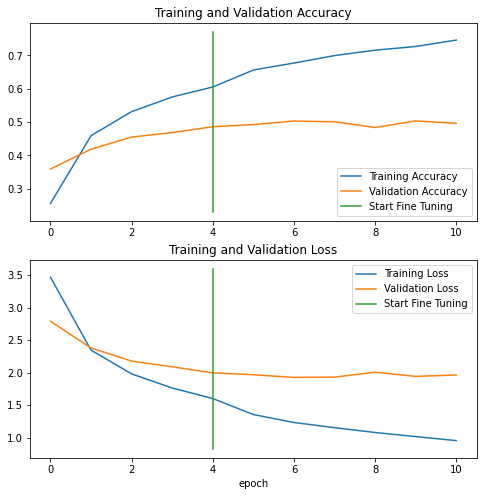

In [ ]:
compare_historys(original_history=history1, new_history=history2, initial_epochs=5)

In [ ]:
#Saving our model
model.save("drive/MyDrive/ColabModels/TransferLearningFinalProjectModel.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#Load and evaluate the saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/ColabModels/TransferLearningFinalProjectModel.h5")

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
#Now evaluate loaded model with test dataset
loaded_model.evaluate(test_data)

790/790 [==============================] - 104s 129ms/step - loss: 2.1705 - accuracy: 0.4552


[2.1704556941986084, 0.45524752140045166]

In [ ]:
#Evaluate the performance of the model across all the data samples across classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-11-17 21:12:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 108.177.112.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  57.4MB/s    in 0.8s    

2021-11-17 21:12:43 (57.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
#Load in the saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
#now evaluate the big dog model on the whole test data
big_dog_results=model.evaluate(test_data)
big_dog_results

790/790 [==============================] - 106s 132ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [ ]:
#Making predictions with our trained model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 97s 121ms/step


In [ ]:
#How many predictions are there
len(pred_probs)

25250

In [ ]:
#lets see what the first 10 predictions look like
pred_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [ ]:
print (f'Number of prediction probabilities for sample 0 : {len(pred_probs[0])}')
print (f'What prediction probability sample 0 looks like :\n {pred_probs[0]}')
print (f'The class has the highest prediction probability for our model on sample 0 : {test_data.class_names[tf.argmax(pred_probs[0])]}')

Number of prediction probabilities for sample 0 : 101
What prediction probability sample 0 looks like :
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 

In [ ]:
pred_classes = tf.argmax(pred_probs, axis=1)
pred_classes

<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([ 52,   0,   0, ..., 100,  94, 100])>

In [ ]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [ ]:
#Now unbatch the test dataset and bring it to the shape by unravelling similar to pred_classes
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
len(y_labels)

25250

In [ ]:
#Now lets evaluate sklearn accuracy score
sklearn_accuracy = sklearn.metrics.accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

Now lets create a confusion matrix for the 101 food classes

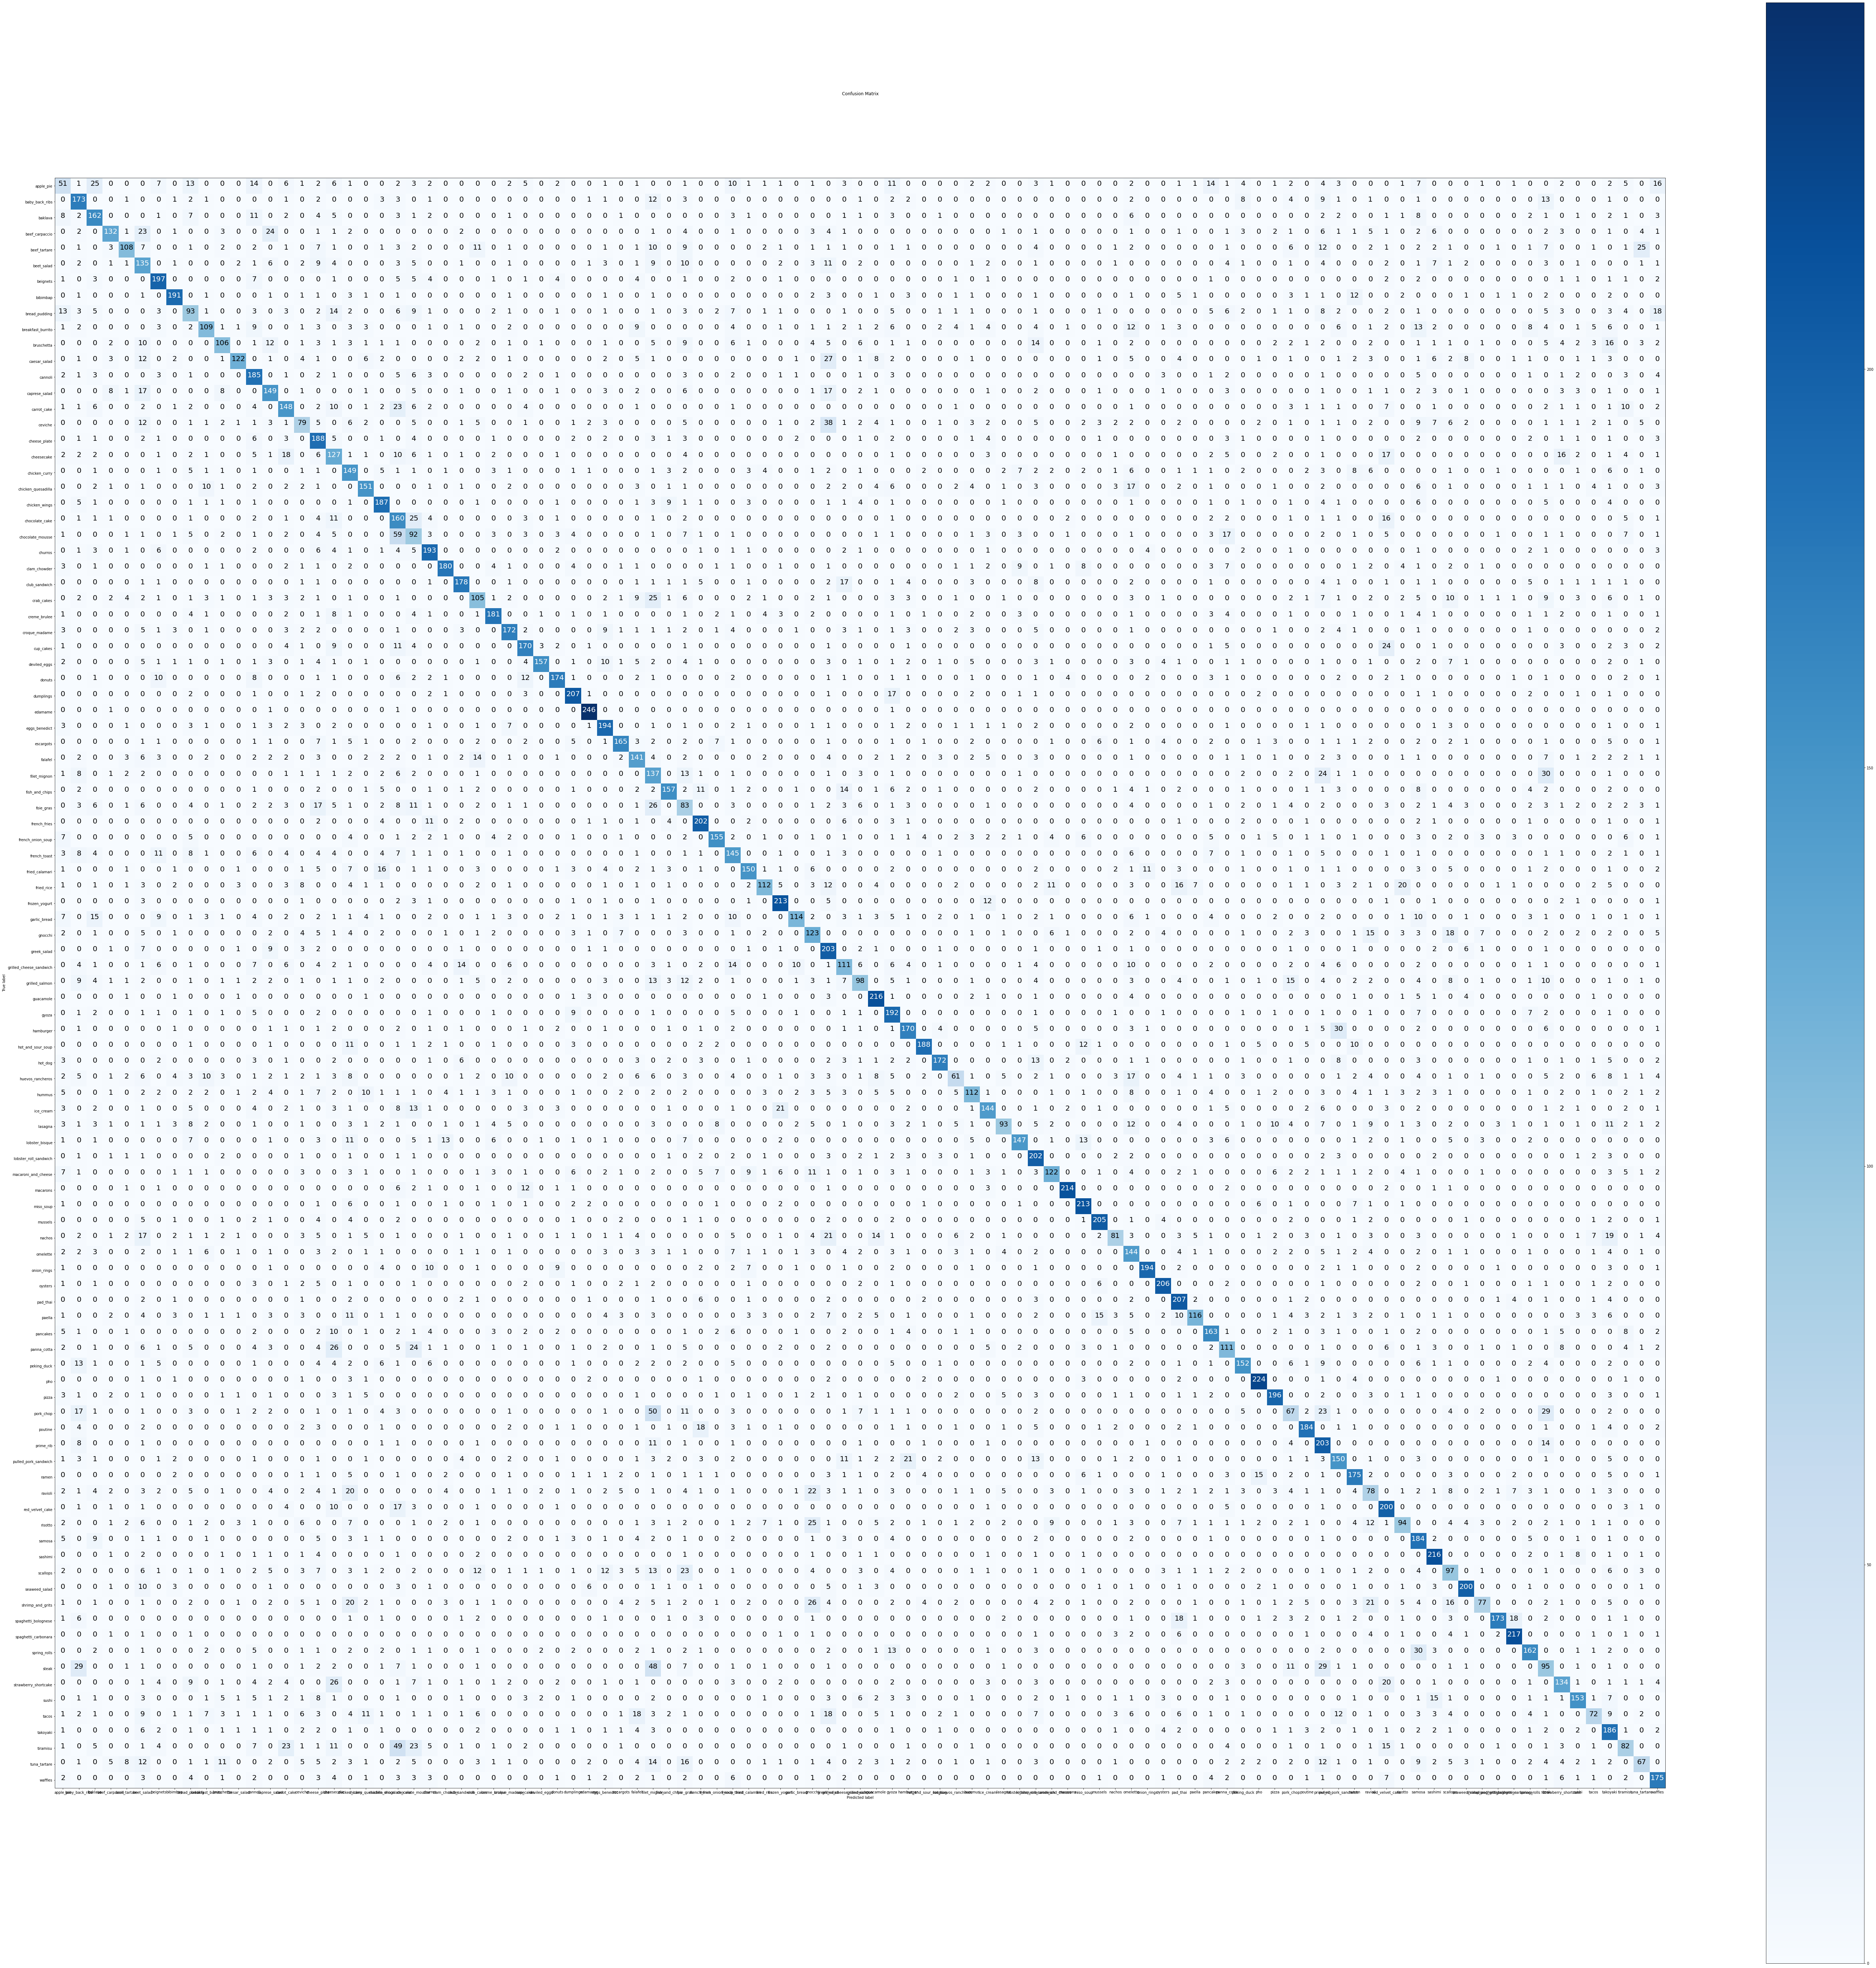

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=test_data.class_names, figsize=(100,100), text_size=20)

In [ ]:
#We gotta make changes to the current create_confusion_matrix method

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #These are the changes made
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

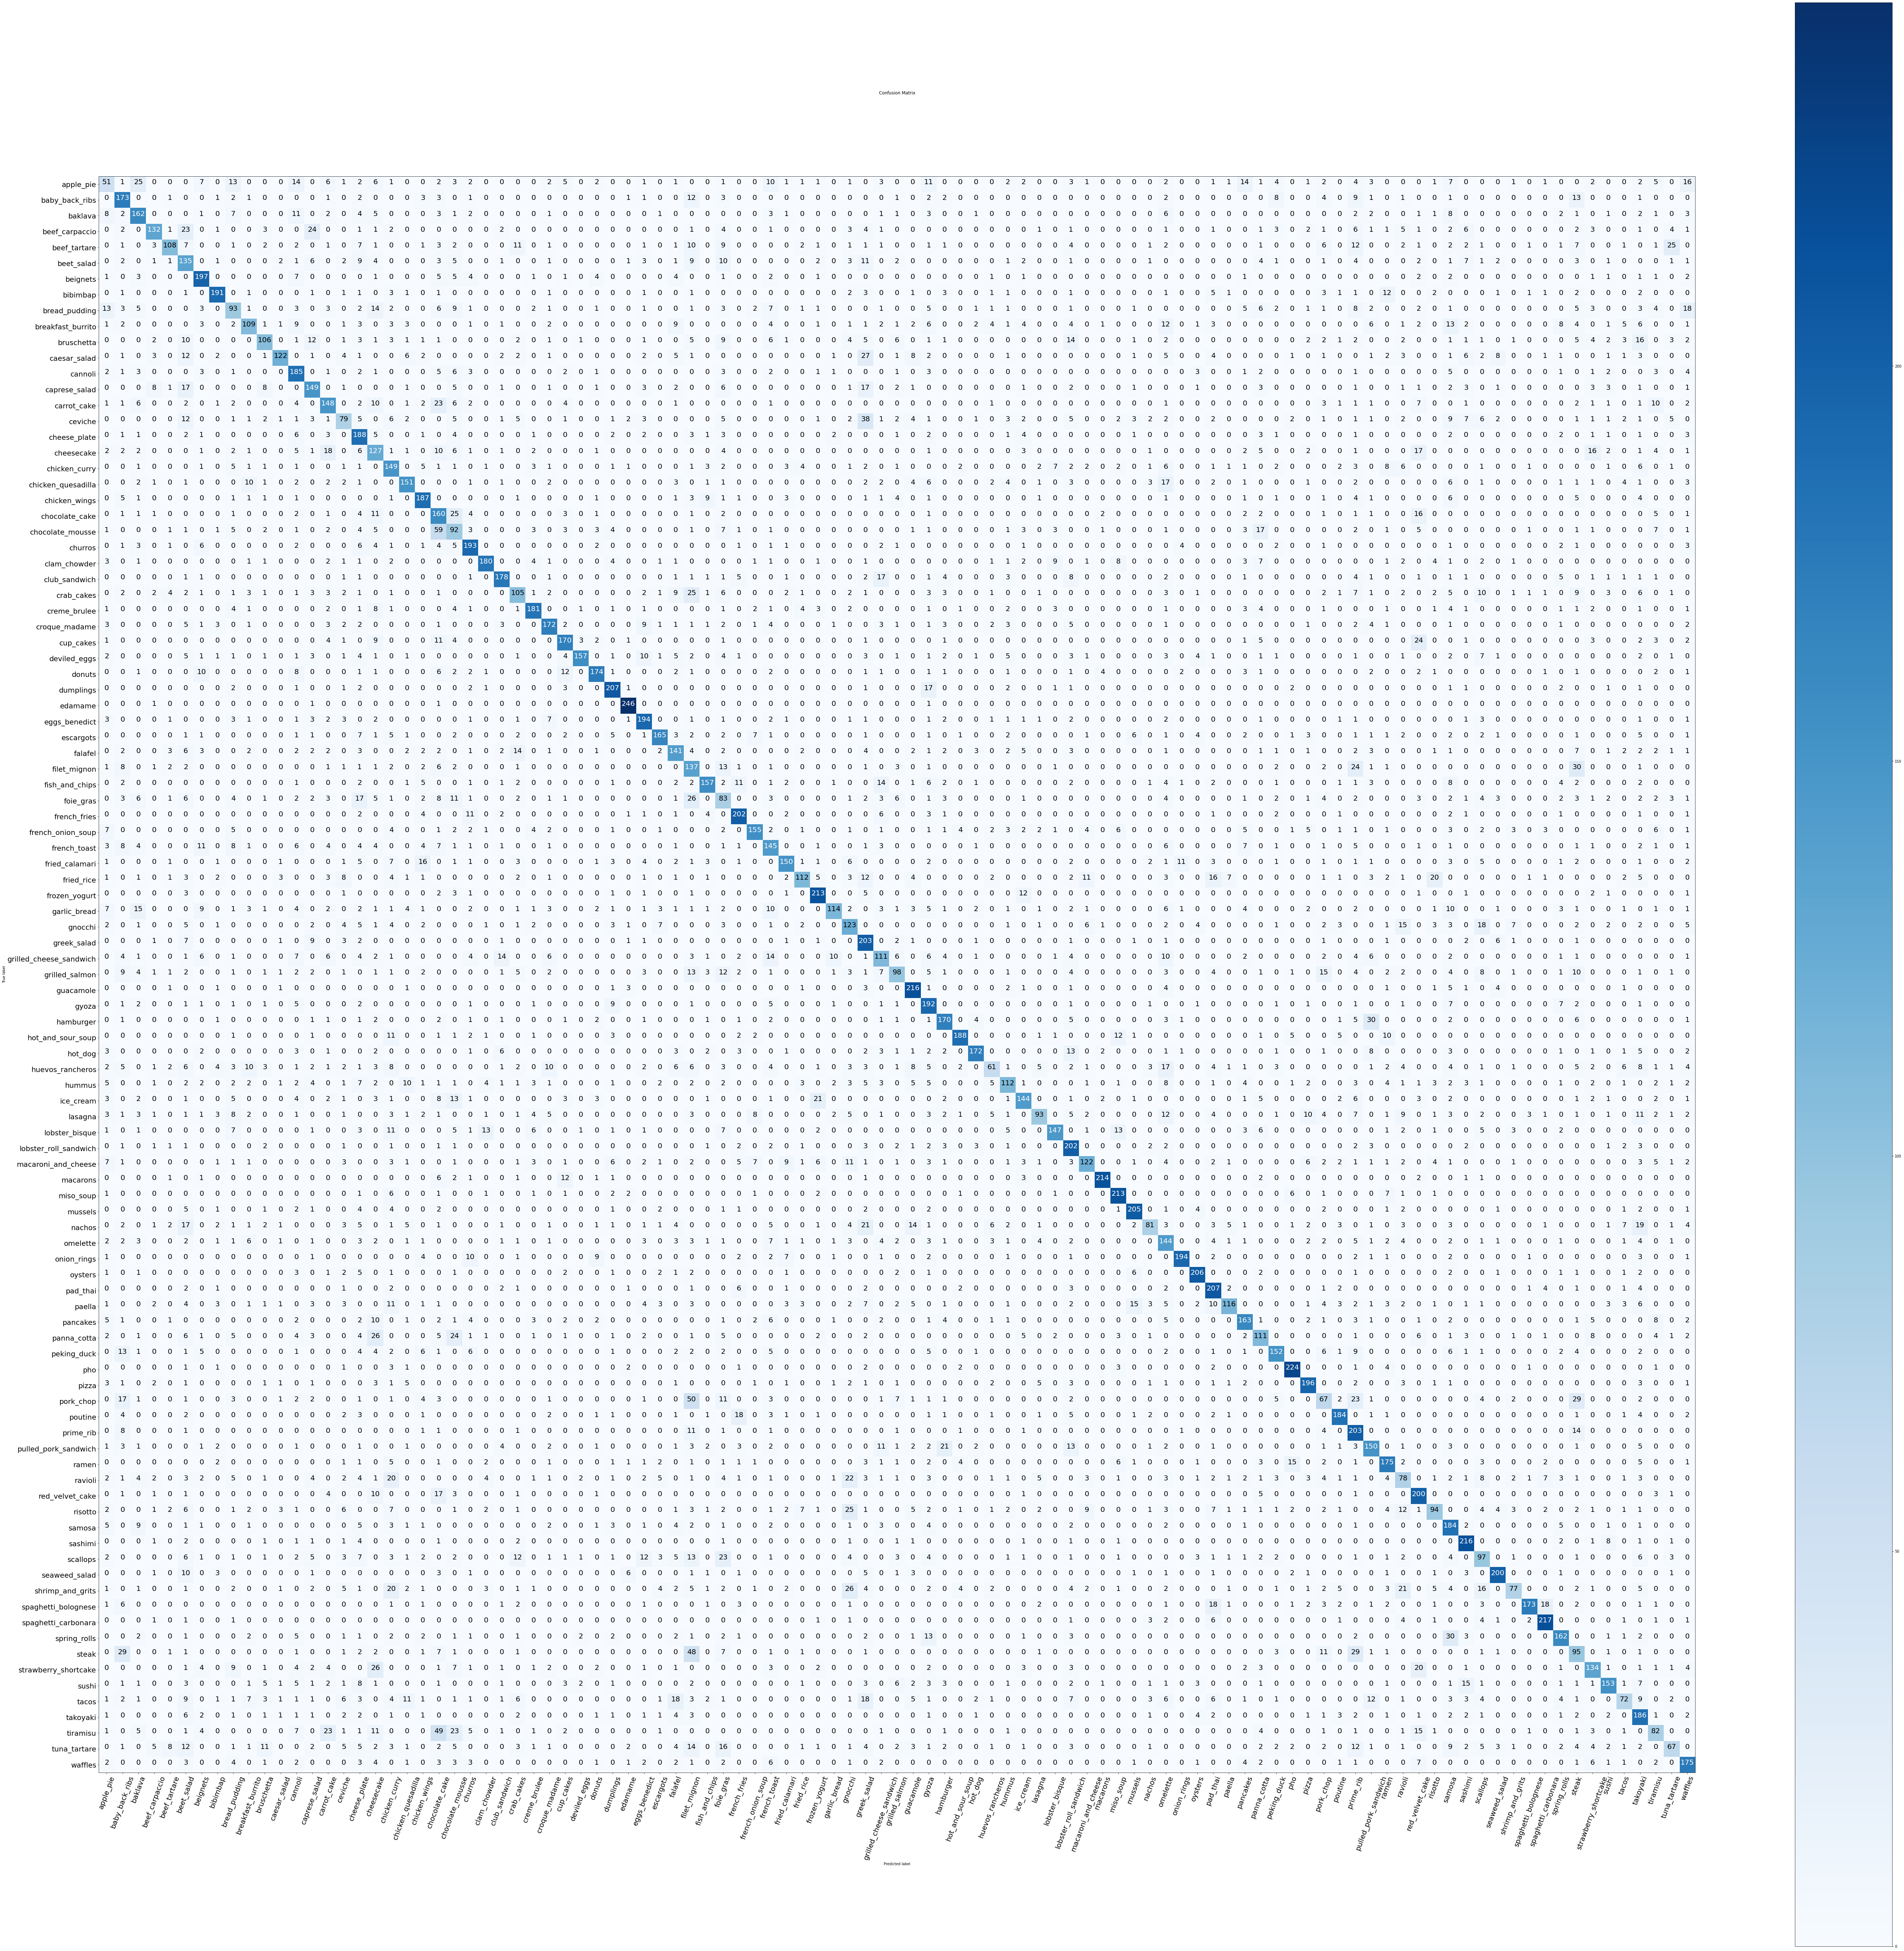

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=test_data.class_names, figsize=(100,100), text_size=20)

lets keep the evaluation phase going and find out various other metrics like precision, recall, classfication report, etc..

In [ ]:
from sklearn.metrics import classification_report

print (classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification reports
classification_dict_report = classification_report(y_labels, pred_classes, output_dict=True)
classification_dict_report

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [ ]:
class_names = test_data.class_names

In [ ]:
# Lets plot all of our clases F1-scores

# Create empty dictionaries
class_f1_scores = {}
# Look through clasification report dictionary items
for k, v in classification_dict_report.items():
  if k == 'accuracy':
    break
  else:
    # Add classnames and F1 scores to the empty dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
#Turn f1-scores to a data frame for visualisation
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-scores' : list(class_f1_scores.values())}).sort_values('f1-scores', ascending=False)
f1_scores[:10]

class_names  f1-scores
33              edamame   0.937143
63             macarons   0.895397
75                  pho   0.866538
91  spaghetti_carbonara   0.847656
69              oysters   0.834008
68          onion_rings   0.832618
65              mussels   0.820000
88        seaweed_salad   0.813008
64            miso_soup   0.812977
45        frozen_yogurt   0.811429

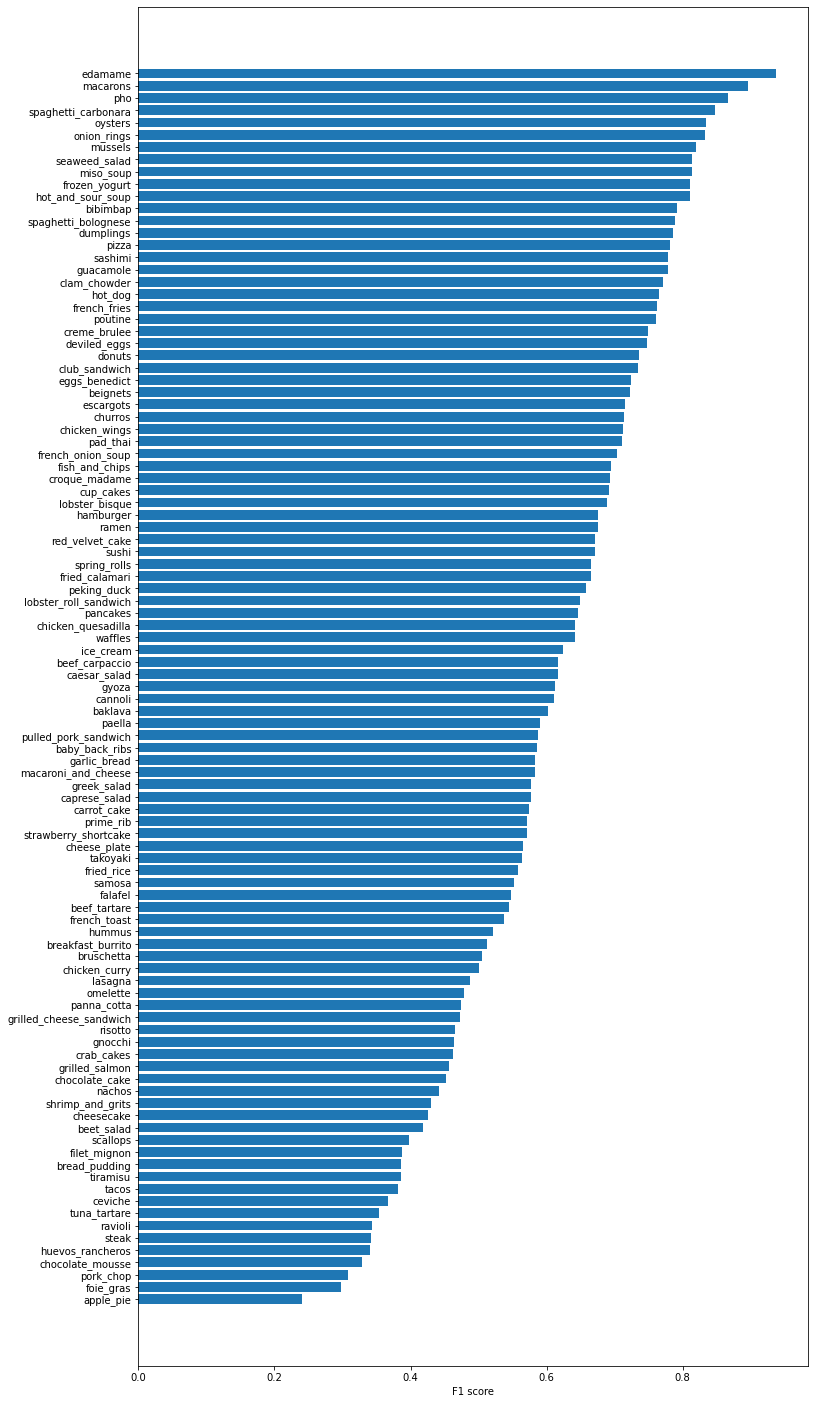

In [ ]:
fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-scores'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1 score')
ax.set_label('F1 scores of all the different 101 classes predicted by our model')
ax.invert_yaxis();

### Visualising predictions on custom images

Create a function to load and preprocess images
* Read in a target image file (using tf.io.read_file())
* Turn the image into a tensor to be used as the same size of the images
* Resize thw image tensor
* Scale the images if necessary

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  #Read in the file
  img = tf.io.read_file(filename)
  #Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)
  #Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale (yes/no)
  if scale:
    return img/255.
  else:
    return img

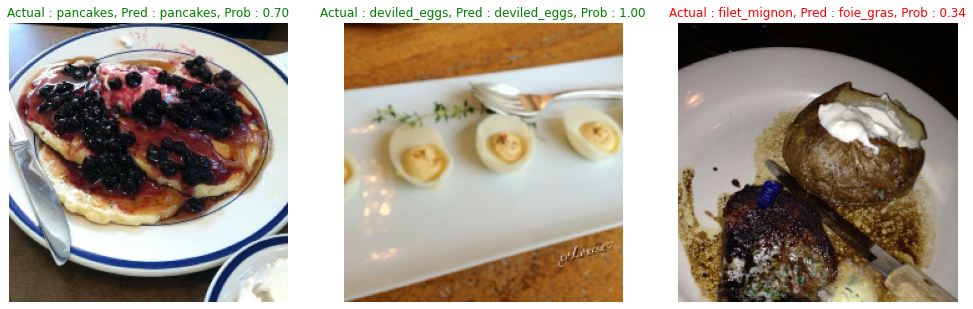

In [ ]:
#Make preds on a series of random images

plt.figure(figsize=(17,10))
for i in range (3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir + class_name + '/' + filename

  #Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  
  #Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255)
  if class_name == pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f'Actual : {class_name}, Pred : {pred_class}, Prob : {pred_prob.max():.2f}', c=title_color)
  plt.axis(False);

##Now lets see how to discover the predictions that our model got very wrong (with the highest wrong prediction probablity)





It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

* Get all of the image file paths in the test dataset using the list_files() method.
* Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
* Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
* Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
* Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
#Get all the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
#Create a dataframe of different parameters for each of the images
pred_pd = pd.DataFrame({"img_path": filepaths,
                        "y_true" : y_labels,
                        "y_pred" : pred_classes,
                        "pred_conf" : pred_probs.max(axis=-1),
                        "y_true_classname" : [class_names[i] for i in y_labels],
                        "y_pred_classname" : [class_names[i] for i in pred_classes]})
pred_pd

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [ ]:
pred_pd['pred_correct'] = pred_pd['y_true'] == pred_pd['y_pred']

In [ ]:
#Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_pd[pred_pd['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong[:20]

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

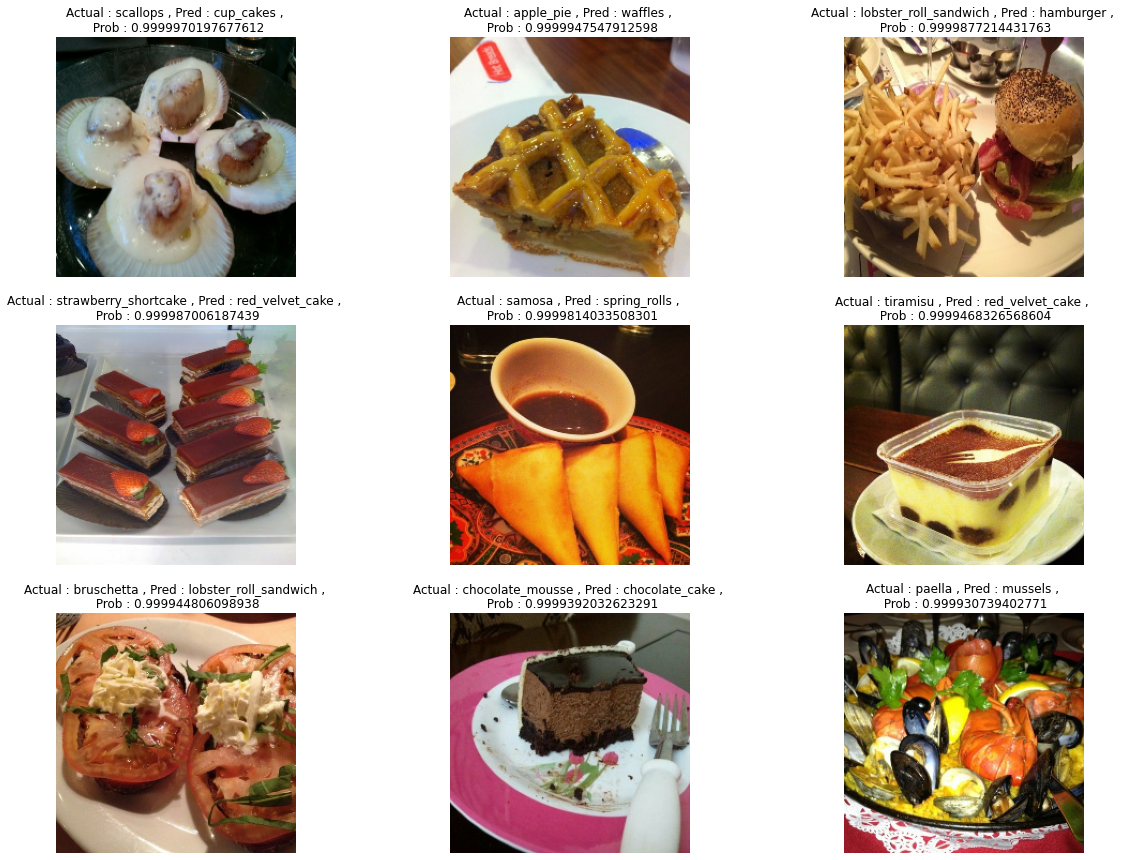

In [ ]:
images_to_view = 9
start_index = 0
plt.figure(figsize=(20,15))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _,_,_,_,pred_prob,y_true_classname,y_pred_classname,_ = row #Only interested in a few parameters in a tuple
  plt.imshow(img/255.)
  plt.title(f'Actual : {y_true_classname} , Pred : {y_pred_classname} , \n Prob : {pred_prob}')
  plt.axis(False);

Test our Big Dog Model on our own custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2021-11-17 23:15:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  51.5MB/s    in 0.2s    

2021-11-17 23:15:10 (51.5 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg']

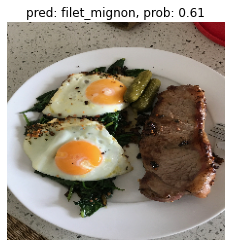

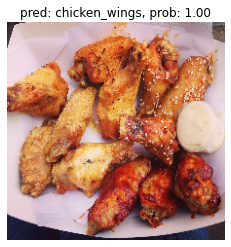

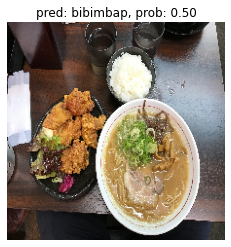

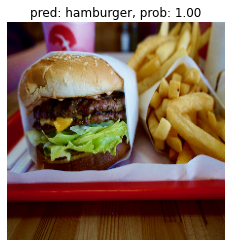

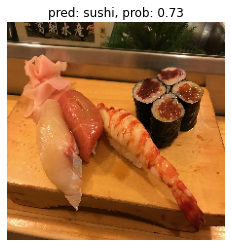

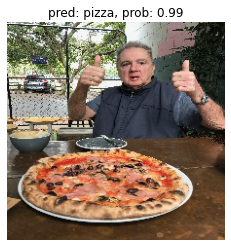

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)